* PAPER - MLP-Mixer: An all-MLP Architecture for Vision - [PDF](https://arxiv.org/pdf/2105.01601.pdf)
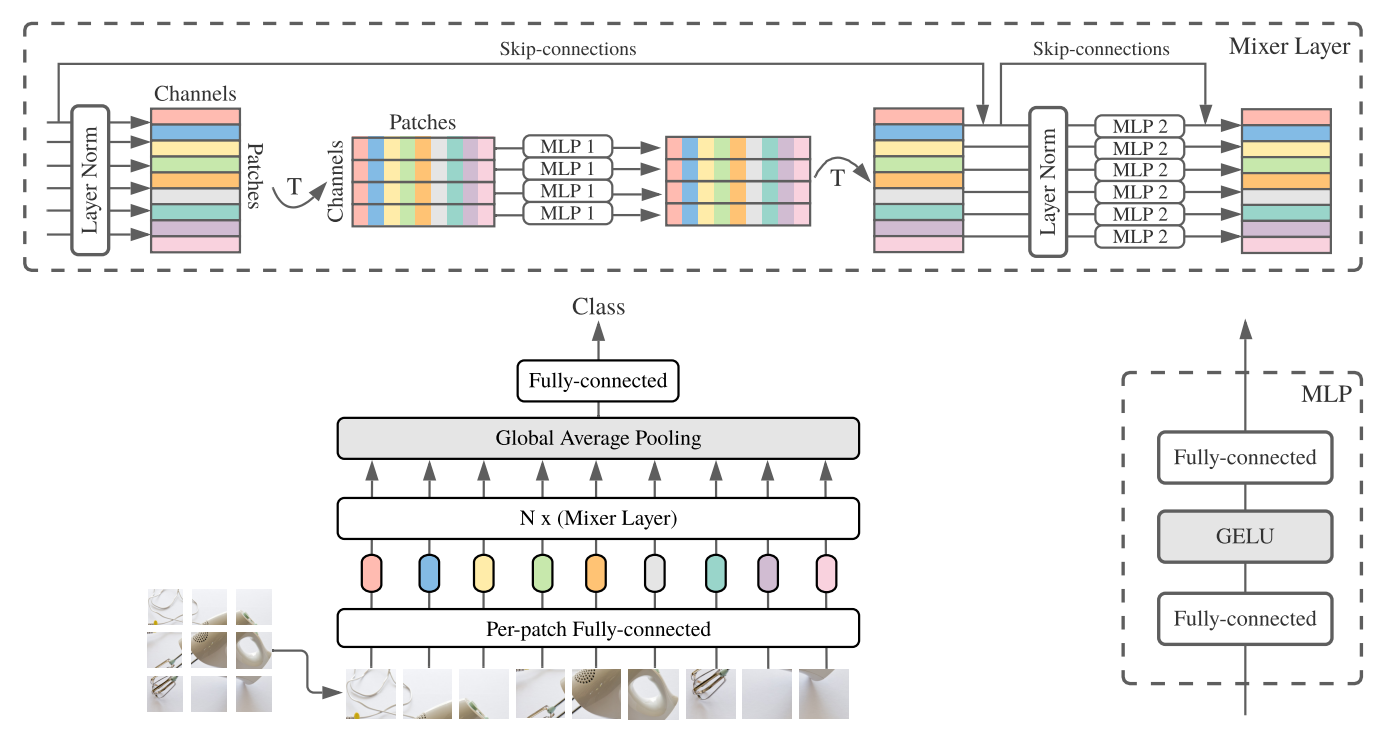
* PAPER - FNet: Mixing Tokens with Fourier Transforms - [PDF](https://arxiv.org/pdf/2105.03824.pdf)
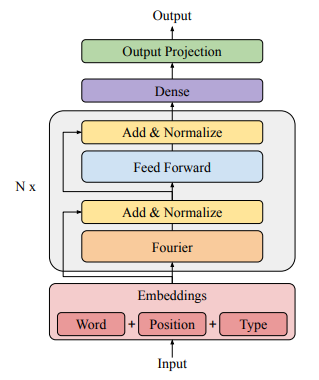
* PAPER - Pay Attention to MLPs(gMLP) - [PDF](https://arxiv.org/pdf/2105.08050.pdf)
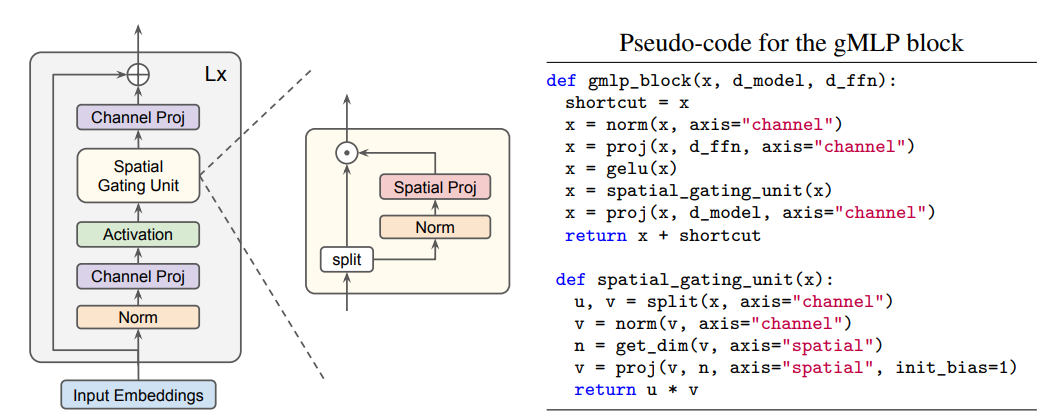

# 준비

## 라이브러리 호출

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings(action='ignore')

from termcolor import colored
from tqdm.notebook import tqdm

## 데이터

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 하이퍼 파라미터 설정

In [20]:
WEIGHT_DECAY = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## 증강

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# 모델링

## Patch

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size # 패치의 사지으
        self.num_patches = num_patches # 패치 개수

    def call(self, images):
        batch_size = tf.shape(images)[0] # 배치 개수
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

## Classification model

In [6]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs) # 전처리 + 증강
    patches = Patches(patch_size, num_patches)(augmented) # 이미지를 패치로 나눔
    x = layers.Dense(units=embedding_dim)(patches) # 패치 임베딩
    
    if positional_encoding: #positional 임베딩 유/무
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embedding_dim)(positions)
        x = x + position_embedding
        
    x = blocks(x) # 모듈블럭
   
    representation = layers.GlobalAveragePooling1D()(x) # [batch_size, embedding_dim] 로 GAP1D   
    representation = layers.Dropout(rate=dropout_rate)(representation) # Apply dropout.
    logits = layers.Dense(num_classes)(representation) # output

    return keras.Model(inputs=inputs, outputs=logits)

## warmup_cosine

In [8]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## 컴파일 및 훈련

In [18]:
def run_experiment(model):
    total_steps = int((len(x_train) / batch_size) * num_epochs)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=learning_rate,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping],
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# 훈련

## MLP-Mixer module

In [14]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [21]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/100
352/352 [==============================] - 34s 87ms/step - loss: 3.8595 - accuracy: 0.1129 - top-5-accuracy: 0.3185 - val_loss: 3.5331 - val_accuracy: 0.1694 - val_top-5-accuracy: 0.4326
Epoch 2/100
352/352 [==============================] - 30s 85ms/step - loss: 3.3734 - accuracy: 0.1924 - top-5-accuracy: 0.4613 - val_loss: 3.3292 - val_accuracy: 0.2190 - val_top-5-accuracy: 0.5024
Epoch 3/100
352/352 [==============================] - 30s 84ms/step - loss: 3.1646 - accuracy: 0.2281 - top-5-accuracy: 0.5169 - val_loss: 3.0698 - val_accuracy: 0.2564 - val_top-5-accuracy: 0.5492
Epoch 4/100
352/352 [==============================] - 30s 85ms/step - loss: 2.9977 - accuracy: 0.2618 - top-5-accuracy: 0.5591 - val_loss: 2.9993 - val_accuracy: 0.2670 - val_top-5-accuracy: 0.5834
Epoch 5/100
352/352 [==============================] - 29s 84ms/step - loss: 2.8969 - accuracy: 0.2792 - top-5-accuracy: 0.5860 - val_loss: 2.8383 - val_accuracy: 0.3012 - val_top-5-accuracy: 0.6120
Epoch

352/352 [==============================] - 30s 84ms/step - loss: 2.0964 - accuracy: 0.4433 - top-5-accuracy: 0.7602 - val_loss: 2.2118 - val_accuracy: 0.4390 - val_top-5-accuracy: 0.7528
Epoch 43/100
352/352 [==============================] - 29s 84ms/step - loss: 2.0810 - accuracy: 0.4449 - top-5-accuracy: 0.7590 - val_loss: 2.2697 - val_accuracy: 0.4342 - val_top-5-accuracy: 0.7408
Epoch 44/100
352/352 [==============================] - 30s 84ms/step - loss: 2.0931 - accuracy: 0.4431 - top-5-accuracy: 0.7606 - val_loss: 2.3102 - val_accuracy: 0.4234 - val_top-5-accuracy: 0.7420
Epoch 45/100
352/352 [==============================] - 30s 84ms/step - loss: 2.0699 - accuracy: 0.4482 - top-5-accuracy: 0.7622 - val_loss: 2.1944 - val_accuracy: 0.4388 - val_top-5-accuracy: 0.7502
Epoch 46/100
352/352 [==============================] - 30s 85ms/step - loss: 2.0769 - accuracy: 0.4472 - top-5-accuracy: 0.7643 - val_loss: 2.2907 - val_accuracy: 0.4200 - val_top-5-accuracy: 0.7384
Epoch 47/100


352/352 [==============================] - 29s 83ms/step - loss: 1.9590 - accuracy: 0.4711 - top-5-accuracy: 0.7858 - val_loss: 2.1308 - val_accuracy: 0.4572 - val_top-5-accuracy: 0.7664
Epoch 84/100
352/352 [==============================] - 29s 82ms/step - loss: 1.9514 - accuracy: 0.4735 - top-5-accuracy: 0.7859 - val_loss: 2.1714 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.7590
Epoch 85/100
352/352 [==============================] - 30s 84ms/step - loss: 1.9485 - accuracy: 0.4730 - top-5-accuracy: 0.7879 - val_loss: 2.1076 - val_accuracy: 0.4704 - val_top-5-accuracy: 0.7714
Epoch 86/100
352/352 [==============================] - 30s 84ms/step - loss: 1.9349 - accuracy: 0.4776 - top-5-accuracy: 0.7906 - val_loss: 2.1633 - val_accuracy: 0.4582 - val_top-5-accuracy: 0.7636
Epoch 87/100
352/352 [==============================] - 30s 85ms/step - loss: 1.9416 - accuracy: 0.4756 - top-5-accuracy: 0.7884 - val_loss: 2.1201 - val_accuracy: 0.4632 - val_top-5-accuracy: 0.7696
Epoch 88/100


## FNet

In [23]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [24]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history2 = run_experiment(fnet_classifier)

Epoch 1/100
352/352 [==============================] - 32s 83ms/step - loss: 4.1103 - accuracy: 0.0744 - top-5-accuracy: 0.2340 - val_loss: 3.8057 - val_accuracy: 0.1274 - val_top-5-accuracy: 0.3282
Epoch 2/100
352/352 [==============================] - 29s 84ms/step - loss: 3.7060 - accuracy: 0.1302 - top-5-accuracy: 0.3568 - val_loss: 3.5222 - val_accuracy: 0.1700 - val_top-5-accuracy: 0.4128
Epoch 3/100
352/352 [==============================] - 28s 81ms/step - loss: 3.4501 - accuracy: 0.1729 - top-5-accuracy: 0.4326 - val_loss: 3.2809 - val_accuracy: 0.2012 - val_top-5-accuracy: 0.4746
Epoch 4/100
352/352 [==============================] - 30s 84ms/step - loss: 3.2599 - accuracy: 0.2068 - top-5-accuracy: 0.4863 - val_loss: 3.1178 - val_accuracy: 0.2416 - val_top-5-accuracy: 0.5224
Epoch 5/100
352/352 [==============================] - 30s 85ms/step - loss: 3.0937 - accuracy: 0.2369 - top-5-accuracy: 0.5295 - val_loss: 2.9862 - val_accuracy: 0.2588 - val_top-5-accuracy: 0.5496
Epoch

352/352 [==============================] - 30s 86ms/step - loss: 1.9854 - accuracy: 0.4647 - top-5-accuracy: 0.7767 - val_loss: 2.1832 - val_accuracy: 0.4312 - val_top-5-accuracy: 0.7414
Epoch 43/100
352/352 [==============================] - 29s 84ms/step - loss: 1.9676 - accuracy: 0.4697 - top-5-accuracy: 0.7815 - val_loss: 2.1614 - val_accuracy: 0.4396 - val_top-5-accuracy: 0.7468
Epoch 44/100
352/352 [==============================] - 29s 83ms/step - loss: 1.9577 - accuracy: 0.4697 - top-5-accuracy: 0.7843 - val_loss: 2.1554 - val_accuracy: 0.4374 - val_top-5-accuracy: 0.7348
Epoch 45/100
352/352 [==============================] - 30s 85ms/step - loss: 1.9445 - accuracy: 0.4746 - top-5-accuracy: 0.7862 - val_loss: 2.1355 - val_accuracy: 0.4436 - val_top-5-accuracy: 0.7450
Epoch 46/100
352/352 [==============================] - 29s 83ms/step - loss: 1.9416 - accuracy: 0.4730 - top-5-accuracy: 0.7868 - val_loss: 2.2188 - val_accuracy: 0.4220 - val_top-5-accuracy: 0.7306
Epoch 47/100


## gMLP

In [25]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [26]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history3 = run_experiment(gmlp_classifier)

Epoch 1/100
352/352 [==============================] - 35s 92ms/step - loss: 3.9176 - accuracy: 0.0972 - top-5-accuracy: 0.2993 - val_loss: 3.5952 - val_accuracy: 0.1386 - val_top-5-accuracy: 0.3962
Epoch 2/100
352/352 [==============================] - 32s 90ms/step - loss: 3.4629 - accuracy: 0.1682 - top-5-accuracy: 0.4320 - val_loss: 3.2762 - val_accuracy: 0.2146 - val_top-5-accuracy: 0.4890
Epoch 3/100
352/352 [==============================] - 32s 91ms/step - loss: 3.2609 - accuracy: 0.2063 - top-5-accuracy: 0.4872 - val_loss: 3.0940 - val_accuracy: 0.2456 - val_top-5-accuracy: 0.5336
Epoch 4/100
352/352 [==============================] - 33s 93ms/step - loss: 3.0694 - accuracy: 0.2431 - top-5-accuracy: 0.5389 - val_loss: 2.9530 - val_accuracy: 0.2782 - val_top-5-accuracy: 0.5676
Epoch 5/100
352/352 [==============================] - 32s 91ms/step - loss: 2.9401 - accuracy: 0.2694 - top-5-accuracy: 0.5669 - val_loss: 2.9668 - val_accuracy: 0.2756 - val_top-5-accuracy: 0.5638
Epoch

352/352 [==============================] - 33s 93ms/step - loss: 1.7122 - accuracy: 0.5261 - top-5-accuracy: 0.8267 - val_loss: 2.1639 - val_accuracy: 0.4636 - val_top-5-accuracy: 0.7574
Epoch 43/100
352/352 [==============================] - 33s 93ms/step - loss: 1.7018 - accuracy: 0.5304 - top-5-accuracy: 0.8302 - val_loss: 2.1847 - val_accuracy: 0.4560 - val_top-5-accuracy: 0.7618
Epoch 44/100
352/352 [==============================] - 33s 93ms/step - loss: 1.6917 - accuracy: 0.5327 - top-5-accuracy: 0.8310 - val_loss: 2.1896 - val_accuracy: 0.4588 - val_top-5-accuracy: 0.7594
Epoch 45/100
352/352 [==============================] - 34s 97ms/step - loss: 1.6709 - accuracy: 0.5384 - top-5-accuracy: 0.8342 - val_loss: 2.1936 - val_accuracy: 0.4554 - val_top-5-accuracy: 0.7574
Epoch 46/100
352/352 [==============================] - 34s 96ms/step - loss: 1.6662 - accuracy: 0.5392 - top-5-accuracy: 0.8374 - val_loss: 2.1971 - val_accuracy: 0.4614 - val_top-5-accuracy: 0.7640
Epoch 47/100


## 평가

MLP-Mixer result plot


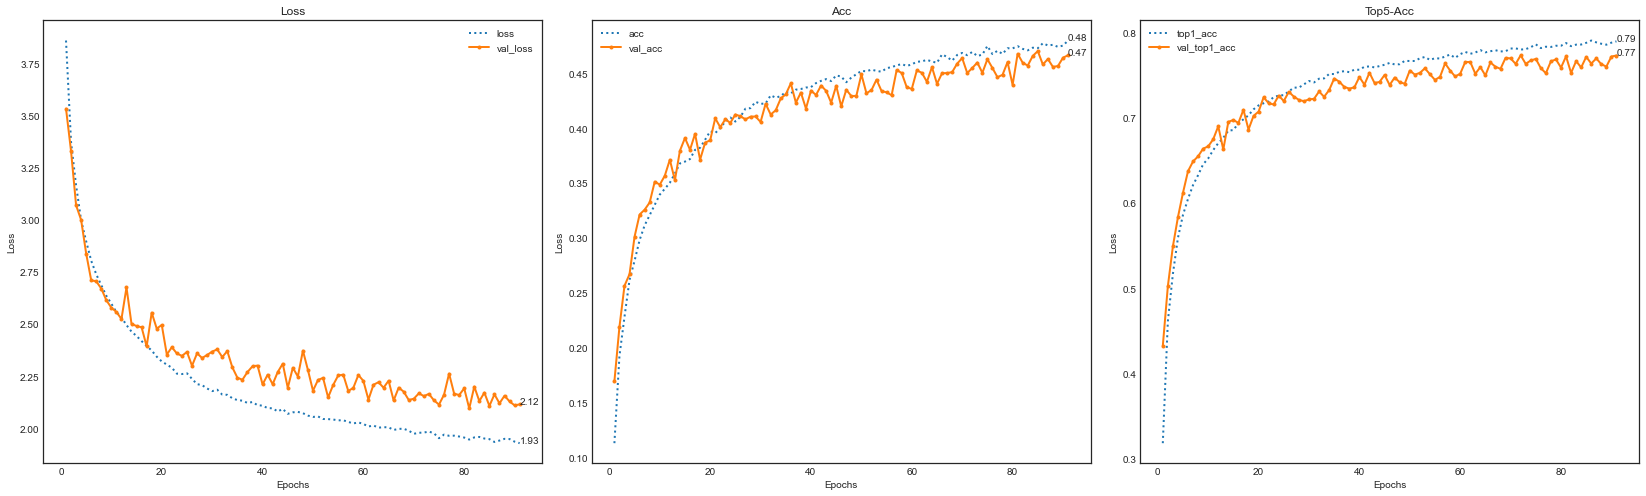

FNet result plot


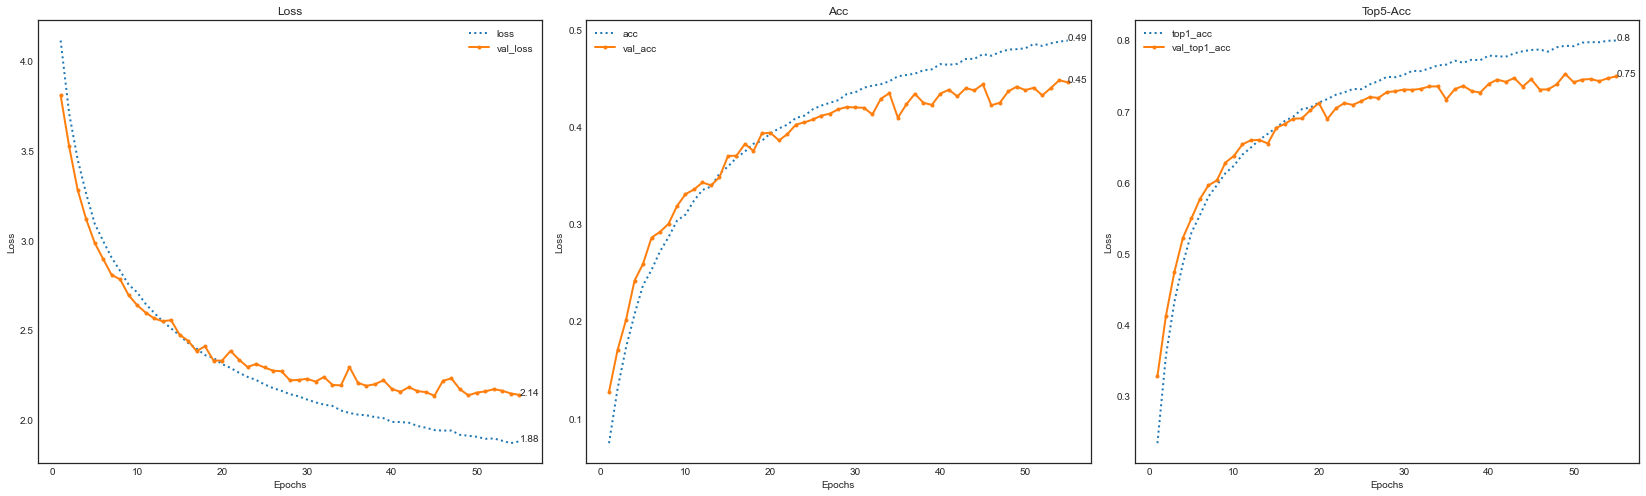

gMLP result plot


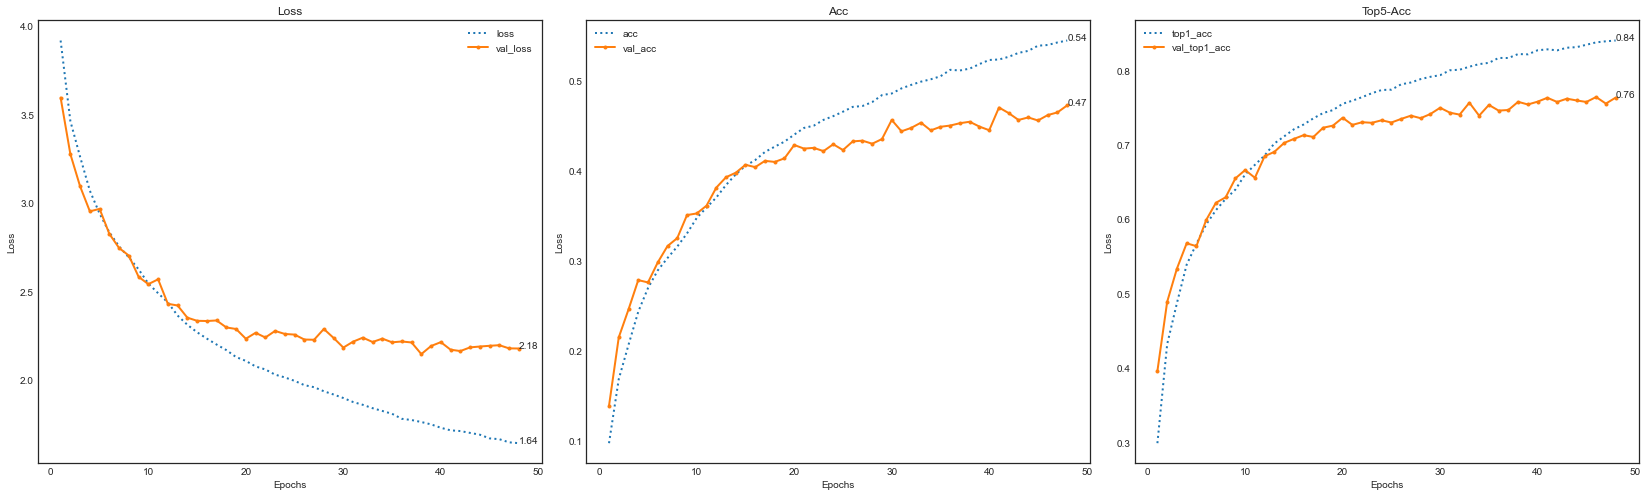

In [39]:
import matplotlib.pyplot as plt

for his , name in zip([history, history2, history3],["MLP-Mixer", "FNet", "gMLP"]):
    print(f"{name} result plot")
    loss = his.history["loss"]
    val_loss = his.history["val_loss"]

    acc = his.history["accuracy"]
    val_acc = his.history["val_accuracy"]

    top1_acc = his.history["top-5-accuracy"]
    val_top1_acc = his.history["val_top-5-accuracy"]

    plt.figure(figsize=(23,7))
    plt.style.use("seaborn-white")
    # loss 
    plt.subplot(131)
    epochs = range(1, 1+len(loss))
    xbins = range(0, len(loss)+1, 10)
    plt.plot(epochs, loss, lw=2,linestyle=':', label="loss")
    plt.plot(epochs, val_loss, lw=2,marker='.', label="val_loss")
    plt.xlabel('Epochs');plt.ylabel('Loss')
    x, y = epochs[-1], loss[-1]
    plt.text(x, y, np.round(y,2))
    x, y = epochs[-1], val_loss[-1]
    plt.text(x, y, np.round(y,2))
    plt.legend()
    plt.title("Loss")

    plt.subplot(132)
    plt.plot(epochs, acc, lw=2,linestyle=':', label="acc")
    plt.plot(epochs, val_acc, lw=2,marker='.', label="val_acc")
    plt.xlabel('Epochs');plt.ylabel('Loss')
    x, y = epochs[-1], acc[-1]
    plt.text(x, y, np.round(y,2))
    x, y = epochs[-1], val_acc[-1]
    plt.text(x, y, np.round(y,2))
    plt.legend()
    plt.title("Acc")

    plt.subplot(133)
    plt.plot(epochs, top1_acc, lw=2,linestyle=':',label="top1_acc")
    plt.plot(epochs, val_top1_acc, lw=2,marker='.', label="val_top1_acc")
    plt.xlabel('Epochs');plt.ylabel('Loss')
    x, y = epochs[-1], top1_acc[-1]
    plt.text(x, y, np.round(y,2))
    x, y = epochs[-1], val_top1_acc[-1]
    plt.text(x, y, np.round(y,2))
    plt.legend()
    plt.title("Top5-Acc")

    plt.tight_layout()
    plt.show()